将 `classify-leaves` 放在根目录的 `dataset` 文件夹下，然后加载一下数据集：

In [1]:
from data_prepare import LeavesData, train_transform, test_transform

leaves_train = LeavesData(mode='train', transform=train_transform)
leaves_test = LeavesData(mode='test', transform=test_transform)
id_to_class = leaves_train.id_to_class
print('类别数', len(id_to_class))

Finished reading the train set of Leaves Dataset (18353 samples found)
Finished reading the test set of Leaves Dataset (8800 samples found)
类别数 176


来看看数据长什么样子：

In [2]:
leaves_train[0][0].shape, leaves_train[0][1], id_to_class[leaves_train[0][1]]

(torch.Size([3, 224, 224]), 78, 'maclura_pomifera')

In [3]:
%matplotlib inline
from d2l import torch as d2l
import torch

def get_labels(labels):  
    """返回Fashion-MNIST数据集的文本标签。"""
    return [id_to_class[int(i)] for i in labels]
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i], fontsize=8)
    return axes

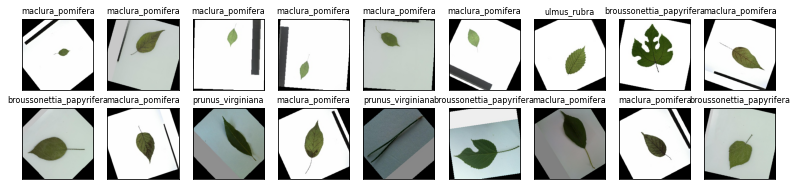

In [4]:
from torch.utils import data

X, y = next(iter(data.DataLoader(leaves_train, batch_size=18)))
show_images(X.reshape(18, 3, 224, 224).numpy().transpose(0, 2, 3, 1), 2, 9, titles=get_labels(y));

使用 sklean 进行 k 折交叉验证：

In [5]:
from sklearn.model_selection import KFold

n_splits=10

kfold = KFold(n_splits=n_splits, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(leaves_train)):
        print(f'Training for fold {fold}/{n_splits}...')
        print(len(train_ids), len(val_ids))
        train_subsampler = data.SubsetRandomSampler(train_ids)
        val_subsampler = data.SubsetRandomSampler(val_ids)

Training for fold 0/10...
16517 1836
Training for fold 1/10...
16517 1836
Training for fold 2/10...
16517 1836
Training for fold 3/10...
16518 1835
Training for fold 4/10...
16518 1835
Training for fold 5/10...
16518 1835
Training for fold 6/10...
16518 1835
Training for fold 7/10...
16518 1835
Training for fold 8/10...
16518 1835
Training for fold 9/10...
16518 1835


使用预训练模型，然后加上自己的一些层即可:

In [6]:
from pretrainedmodels import se_resnext101_32x4d
model = se_resnext101_32x4d()
print(model)

, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (se_module): SEModule(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
        (fc2): Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
        (sigmoid): Sigmoid()
      )
    )
    (5): SEResNeXtBottleneck(
      (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 1024, kernel

In [7]:
# Copied from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [8]:
from torch import nn

num_classes = 176
feature_extract = True
num_ftrs = model.last_linear.in_features
set_parameter_requires_grad(model, feature_extract)
model.last_linear = nn.Linear(num_ftrs, num_classes)
print(model)

5, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (se_module): SEModule(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
        (fc2): Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
        (sigmoid): Sigmoid()
      )
    )
    (5): SEResNeXtBottleneck(
      (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 1024, kerne

In [ ]:
device = d2l.try_gpu()
num_epochs = 10
batch_size = 64
model.to(device)

print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = nn.CrossEntropyLoss()

for fold, (train_ids, val_ids) in enumerate(kfold.split(leaves_train)):
        print(f'Training for fold {fold}/{n_splits}...')
        train_subsampler = data.SubsetRandomSampler(train_ids)
        val_subsampler = data.SubsetRandomSampler(val_ids)
        train_loader = data.DataLoader(
            leaves_train,
            batch_size=batch_size, sampler=train_subsampler)
        val_loader = data.DataLoader(
            leaves_train,
            batch_size=batch_size, sampler=val_subsampler)
        
        animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
        timer, num_batches = d2l.Timer(), len(train_loader)
        for epoch in range(num_epochs):
            print(f'\tTraining for epoch {epoch}')
            # 训练态
            metric = d2l.Accumulator(3)
            model.train()
            for i, (X, y) in enumerate(train_loader):
                timer.start()
                optimizer.zero_grad()
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                l = loss(y_hat, y)
                l.backward()
                optimizer.step()
                with torch.no_grad():
                    metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
                timer.stop()
                train_l = metric[0] / metric[2]
                train_acc = metric[1] / metric[2]
                if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                    animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
            # 测试态
            test_acc = evaluate_accuracy_gpu(net, test_iter)
            animator.add(epoch + 1, (None, None, test_acc))
        print(f'train loss {train_loss:.3f}, '
              f'test loss {test_loss:.3f}')
        print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
              f'on {str(device)}')